In [ ]:
# Important: Set CPU mode before loading libraries
Sys.setenv(CUDA_VISIBLE_DEVICES = "-1")
Sys.setenv(TF_CPP_MIN_LOG_LEVEL = "2")

In [ ]:
install.packages("keras3")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’, ‘dotty’




In [ ]:
install.packages("imager")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bmp’, ‘tiff’, ‘jpeg’, ‘readbitmap’, ‘downloader’, ‘igraph’




In [ ]:
install.packages("yardstick")
library(yardstick)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sparsevctrs’, ‘hardhat’



Attaching package: ‘yardstick’


The following object is masked from ‘package:keras3’:

    get_weights




In [ ]:
library(keras3)
library(imager)

Loading required package: magrittr


Attaching package: ‘imager’


The following object is masked from ‘package:magrittr’:

    add


The following objects are masked from ‘package:stats’:

    convolve, spectrum


The following object is masked from ‘package:graphics’:

    frame


The following object is masked from ‘package:base’:

    save.image




In [ ]:
# Define months
months <- seq(as.Date("2024-01-01"), as.Date("2025-09-01"), by = "month")
n_months <- length(months)   # should be 21

month_ids <- format(months, "%Y_%m")   # "2024_01", "2024_02", ...

img_files <- sprintf("map_%s.png", month_ids)

# Check file names
img_files

[1] "map_2024_01.png" "map_2024_02.png" "map_2024_03.png" "map_2024_04.png"
 [5] "map_2024_05.png" "map_2024_06.png" "map_2024_07.png" "map_2024_08.png"
 [9] "map_2024_09.png" "map_2024_10.png" "map_2024_11.png" "map_2024_12.png"
[13] "map_2025_01.png" "map_2025_02.png" "map_2025_03.png" "map_2025_04.png"
[17] "map_2025_05.png" "map_2025_06.png" "map_2025_07.png" "map_2025_08.png"
[21] "map_2025_09.png"

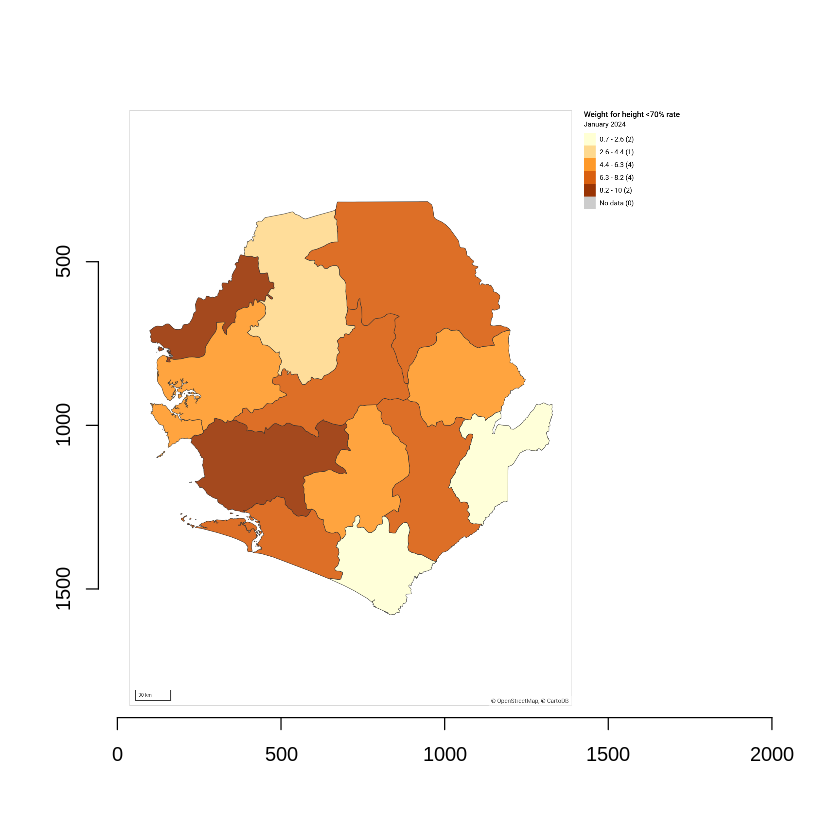

In [ ]:
# Load images
img_list <- lapply(img_files, load.image)
names(img_list) <- format(months, "%Y-%m")

# Check one image
plot(img_list[[1]])

In [ ]:
# cropping legend and excess space out

crop_map <- function(img,
                     crop_right = 590,
                     crop_top = 191,
                     crop_bottom = 297) {

  arr <- as.array(img)

  w <- dim(arr)[1]  # width  (x)
  h <- dim(arr)[2]  # height (y)

  # x-axis: keep 1 ... (w - crop_right)
  x_keep <- 1:(w - crop_right)

  # y-axis: keep (crop_top + 1) ... (h - crop_bottom)
  y_keep <- (crop_top + 1):(h - crop_bottom)

  cropped_arr <- arr[x_keep, y_keep, , , drop = FALSE]
  as.cimg(cropped_arr)
}

[1] 1405 1405    1    4

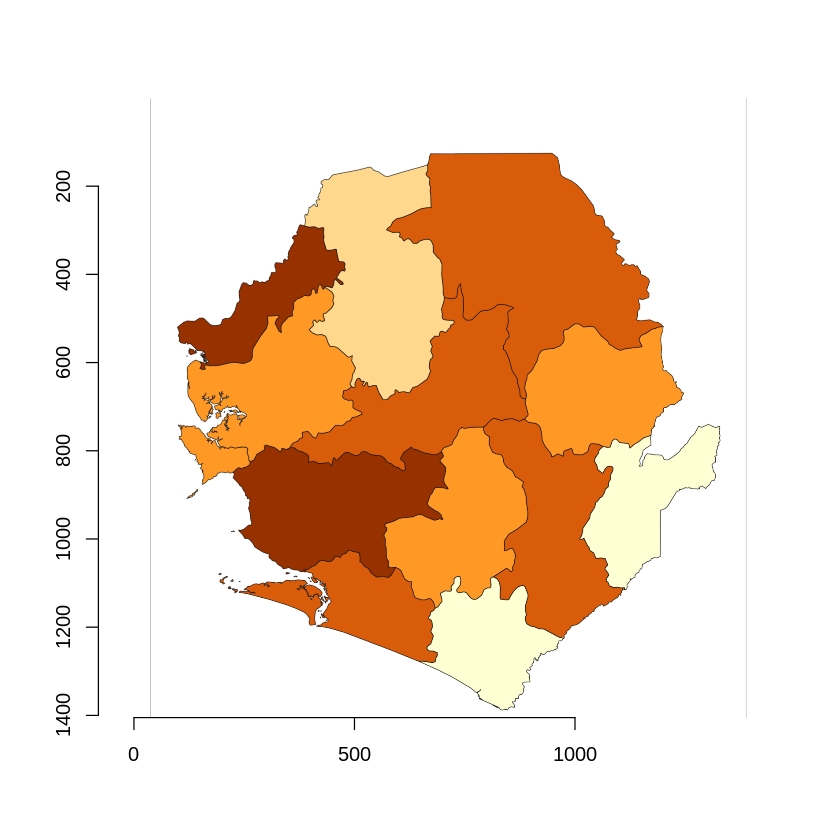

In [ ]:
img_list <- lapply(img_list, crop_map,
                   crop_right = 590,
                   crop_top = 191,
                   crop_bottom = 297)
plot(img_list[[1]])
dim(as.array(img_list[[1]]))

In [ ]:
length(img_list)

[1] 21

In [ ]:
# img: cimg object
get_rgb <- function(img, x, y) {
  # imager indexes as img[x, y, z, cc]
  r <- img[x, y, 1, 1]
  g <- img[x, y, 1, 2]
  b <- img[x, y, 1, 3]
  c(r, g, b)
}

grow_region <- function(img, seed_x, seed_y, color_tol = 0.05, border_thresh = 0.2) {
  dims <- dim(img)
  w <- dims[1]; h <- dims[2]  # x, y

  seed_col <- get_rgb(img, seed_x, seed_y)

  visited <- matrix(FALSE, nrow = w, ncol = h)
  mask    <- matrix(FALSE, nrow = w, ncol = h)

  qx <- seed_x
  qy <- seed_y
  visited[seed_x, seed_y] <- TRUE

  is_border_pixel <- function(col) {
    mean(col) < border_thresh  # tweak this if it eats too much
  }

  while (length(qx) > 0) {
    x <- qx[1]; qx <- qx[-1]
    y <- qy[1]; qy <- qy[-1]

    col <- get_rgb(img, x, y)

    # stop if we hit border line
    if (is_border_pixel(col)) next

    # color distance from seed
    if (sqrt(sum((col - seed_col)^2)) <= color_tol) {
      mask[x, y] <- TRUE

      # 4-connected neighbors
      for (dx in c(-1, 1, 0, 0)) {
        for (dy in c(0, 0, -1, 1)) {
          nx <- x + dx; ny <- y + dy
          if (nx >= 1 && nx <= w && ny >= 1 && ny <= h && !visited[nx, ny]) {
            visited[nx, ny] <- TRUE
            qx <- c(qx, nx)
            qy <- c(qy, ny)
          }
        }
      }
    }
  }

  mask
}

Growing region for Bo 
Growing region for Kambia 


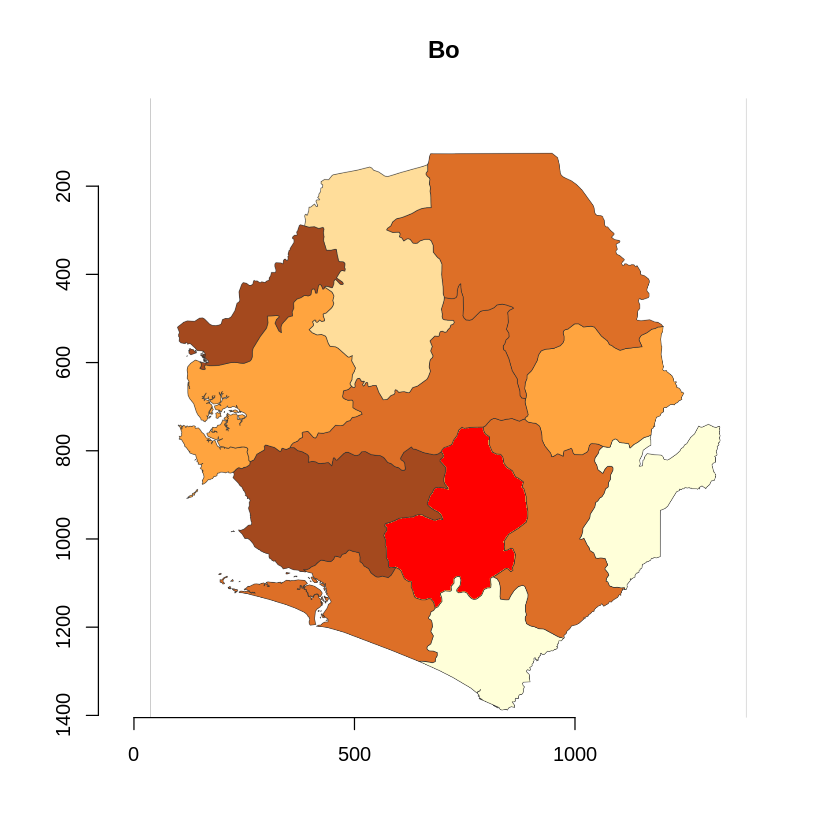

Growing region for Bombali 


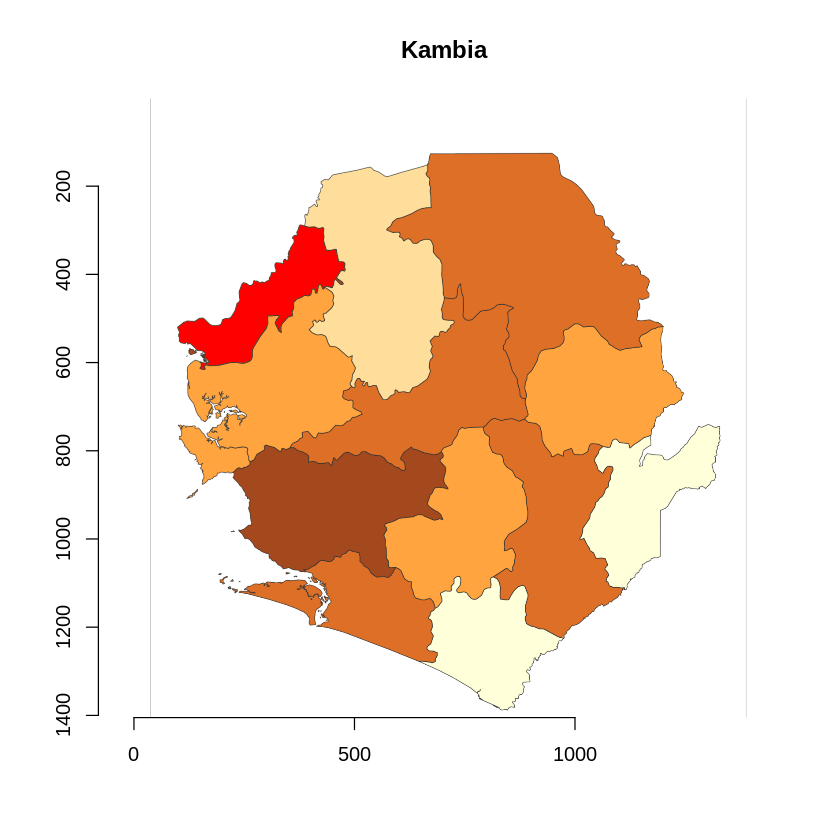

Growing region for Koinadugu 


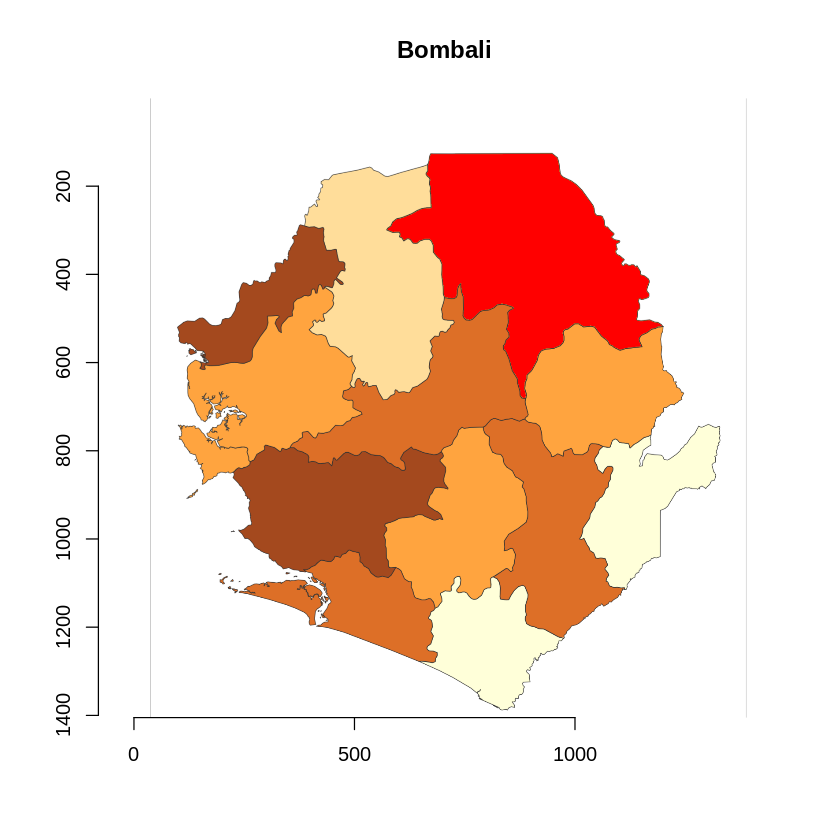

Growing region for Western Area 


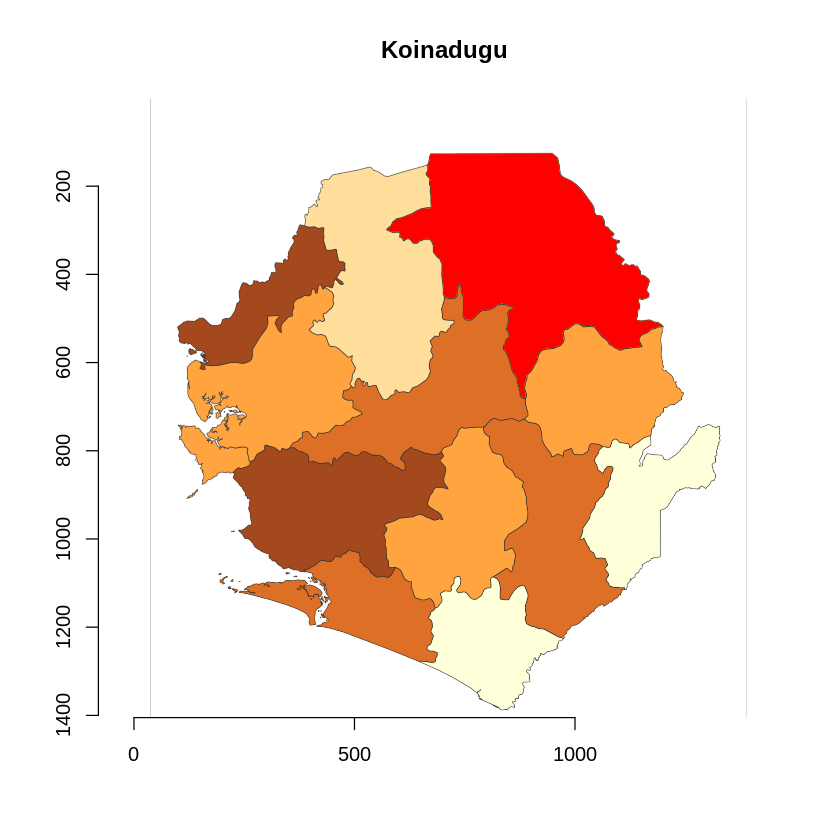

Growing region for Port_Loko 


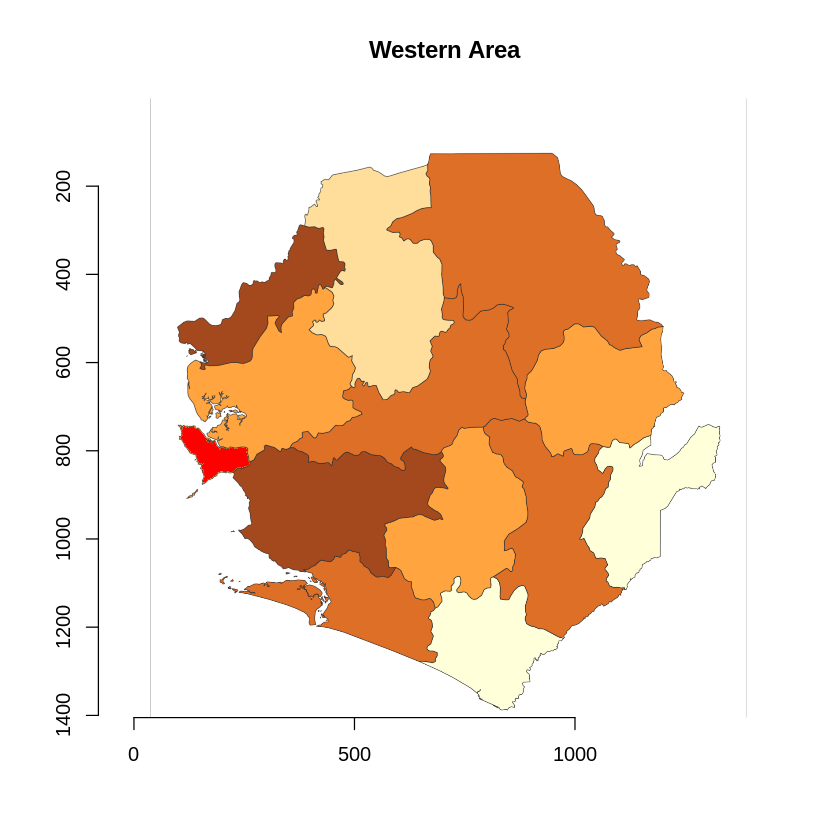

Growing region for Tonkolili 


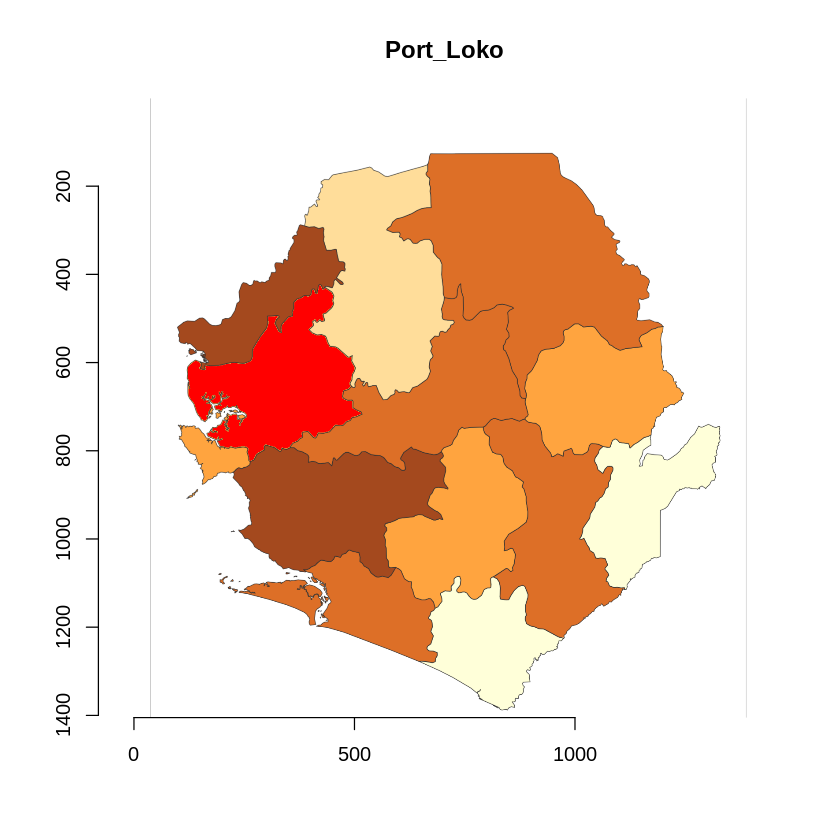

Growing region for Kono 


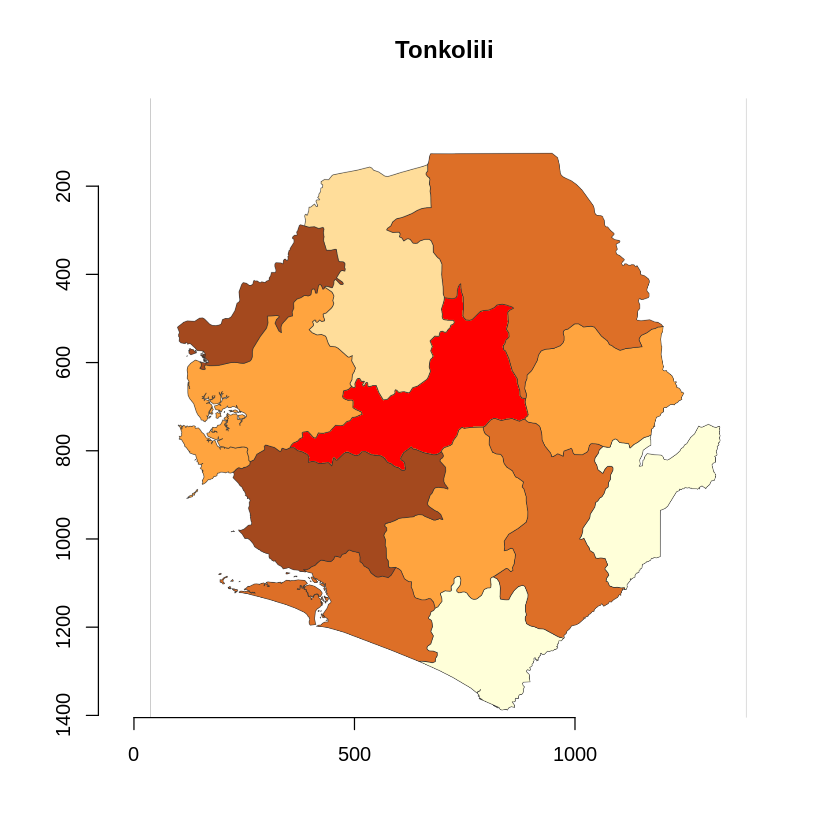

Growing region for Moyamba 


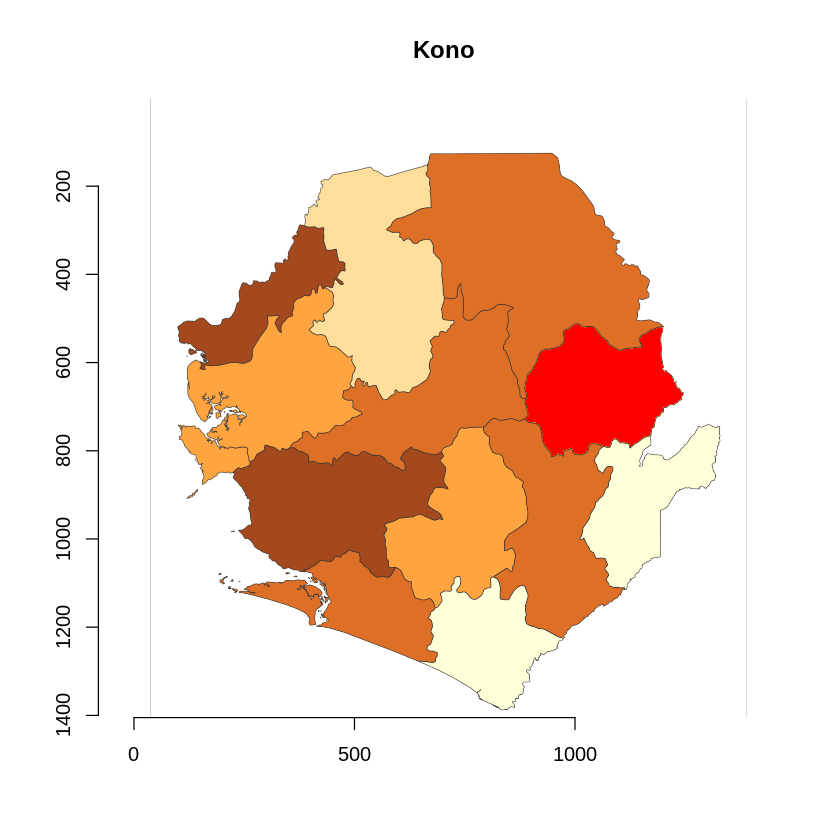

Growing region for Kenema 


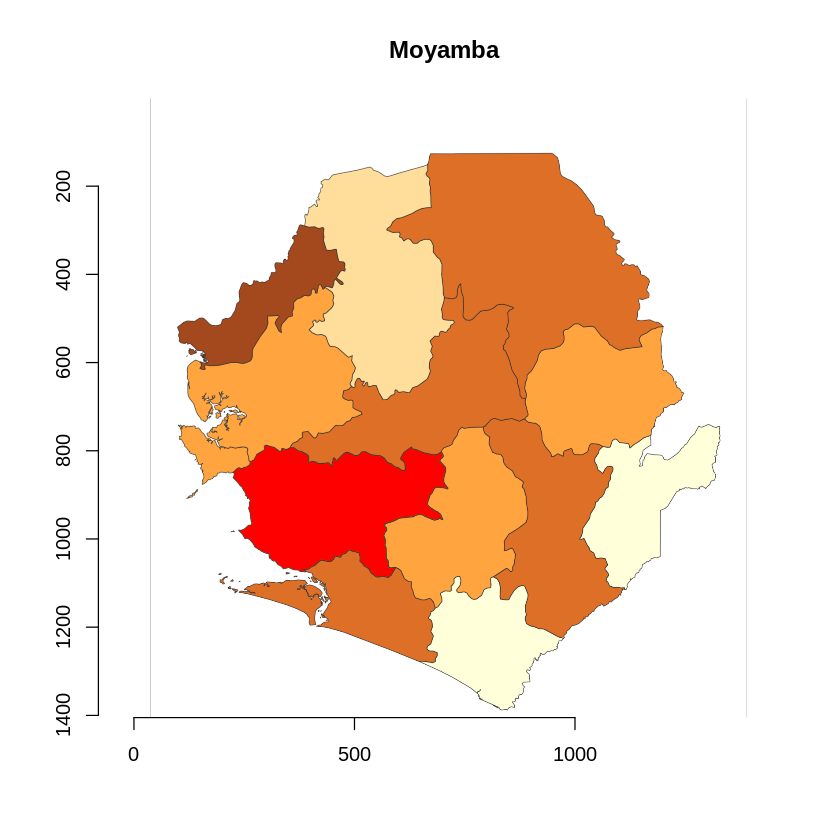

Growing region for Kailahun 


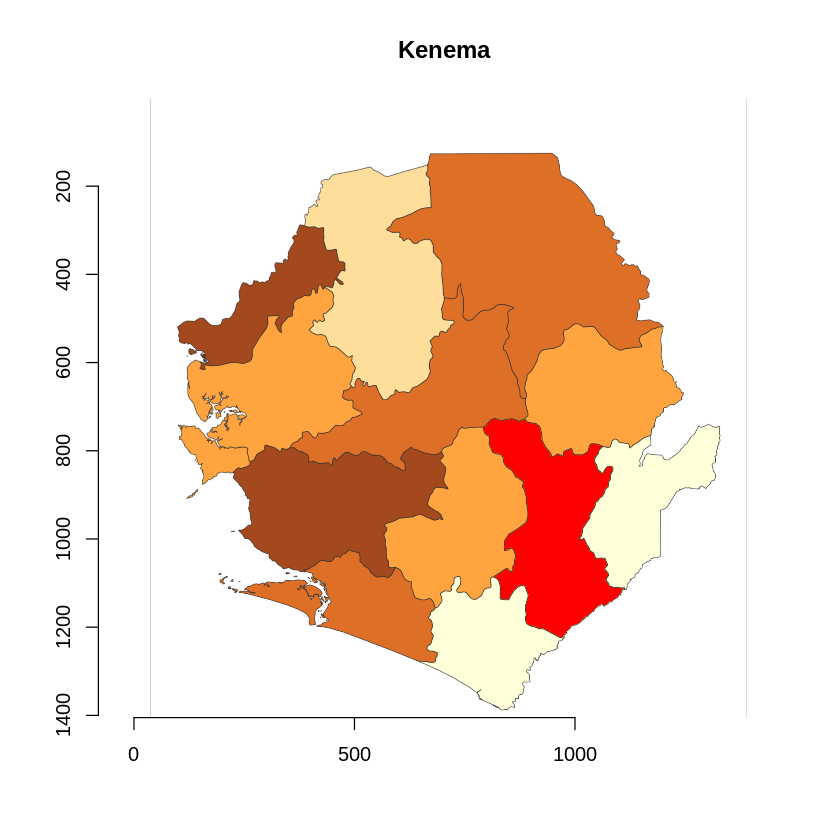

Growing region for Bonthe 


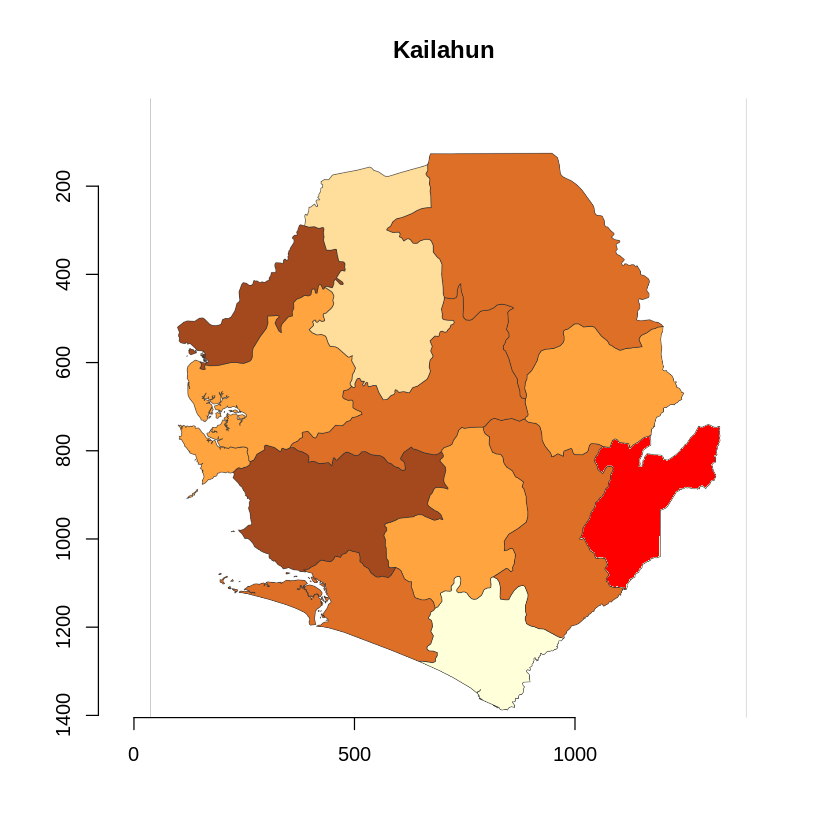

Growing region for Pujehun 


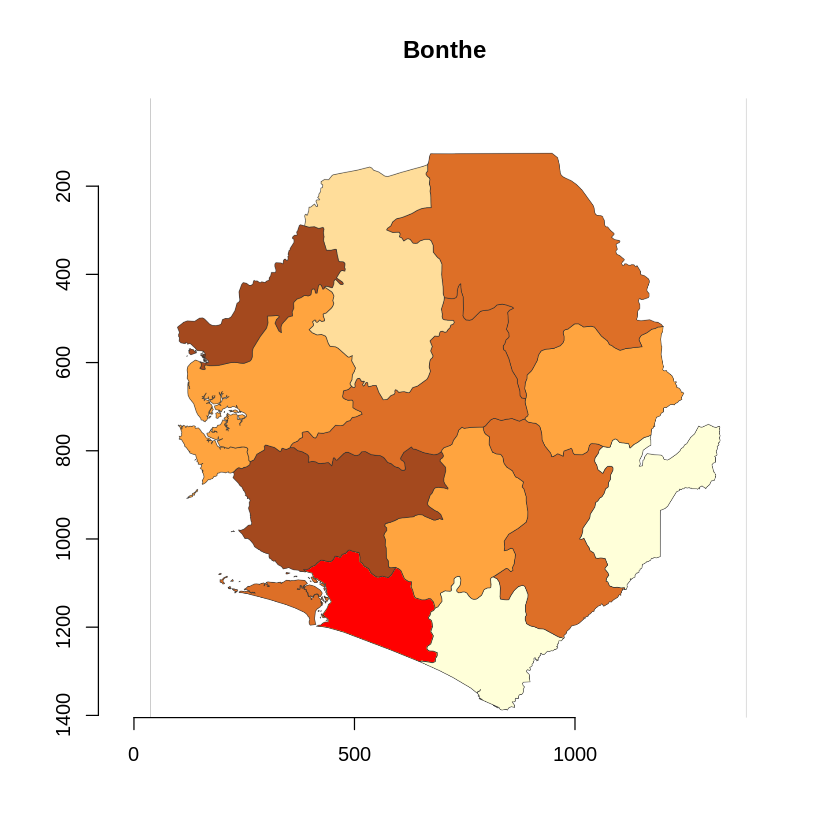

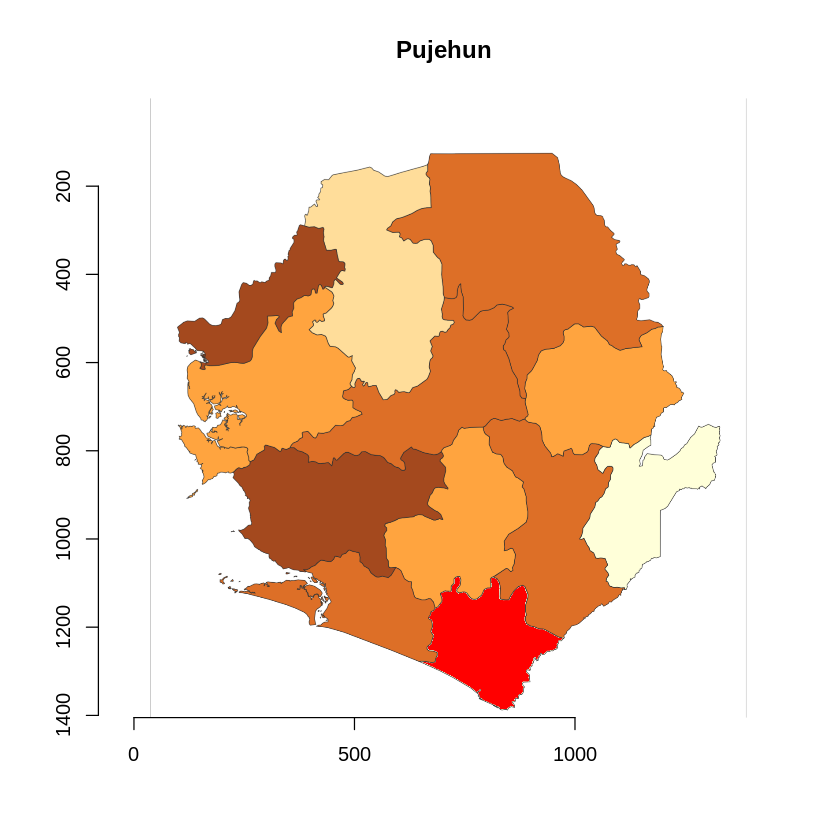

In [ ]:
template <- img_list[[1]]

district_seeds <- data.frame(
  district = c("Bo", "Kambia", "Bombali", "Koinadugu", "Western Area", "Port_Loko", "Tonkolili", "Kono", "Moyamba", "Kenema", "Kailahun", "Bonthe", "Pujehun"),
   x = c(750, 260, 600, 1000, 200, 300, 700, 1000, 500, 900, 1100, 500, 800),
   y = c(1000, 450, 300, 300, 800, 600, 600, 600, 1000, 1050, 1000, 1150, 1300)
)

district_masks <- list()


for (i in 1:nrow(district_seeds)) {
  d  <- district_seeds$district[i]
  sx <- district_seeds$x[i]
  sy <- district_seeds$y[i]

  cat("Growing region for", d, "\n")
  mask <- grow_region(template, seed_x = sx, seed_y = sy, color_tol = 0.05)
  district_masks[[d]] <- mask

  img_arr <- as.array(template)  # dims: x, y, z, cc (z=1, cc=3)

  alpha <- 1
  m <- mask

  # Red channel
  img_arr[,,1,1][m] <- (1 - alpha) * img_arr[,,1,1][m] + alpha * 1
  # Green channel
  img_arr[,,1,2][m] <- (1 - alpha) * img_arr[,,1,2][m] + alpha * 0
  # Blue channel
  img_arr[,,1,3][m] <- (1 - alpha) * img_arr[,,1,3][m] + alpha * 0

  combined <- as.cimg(img_arr)

  plot(combined)
  title(main = d)
}

In [ ]:
# Month Sequence (21 months)

month_seq <- seq.Date(
  from = as.Date("2024-01-01"),
  to   = as.Date("2025-09-01"),
  by   = "month"
)

month_label <- format(month_seq, "%b %Y")

# Create dataframe
district_rates <- data.frame(

  month_date  = month_seq,
  month_label = month_label,

  # -------------------
  #  BO (21 values)
  # -------------------
  Bo = c(
    5.79, 6.71, 5.39, 6.21, 5.40,
    5.03, 4.46, 6.44, 4.79, 5.80,
    4.78, 7.78,
    5.79, 6.71, 6.21, 5.39, 5.40,
    5.03, 5.01, 6.44, 4.79
  ),

  # -------------------
  #  BOMBALI
  # -------------------
  Bombali = c(
    3.53, 1.93, 3.10, 2.83, 2.34,
    2.15, 2.35, 2.75, 3.38, 1.92,
    NA, 2.04,
    3.53, 1.93, 2.83, 3.10, 2.34,
    2.15, 2.35, 2.75, 3.38
  ),

  # -------------------
  #  BONTHE
  # -------------------
  Bonthe = c(
    7.02, 8.47, 2.44, 5.33, 5.79,
    4.09, 6.30, 5.68, 7.71, NA,
    3.69, NA,
    7.02, 8.47, 5.33, 2.44, 5.79,
    4.09, 6.30, 5.68, 7.71
  ),

  # -------------------
  #  KAILAHUN
  # -------------------
  Kailahun = c(
    2.21, 2.89, 2.99, 4.08, 3.59,
    4.15, 4.83, 3.45, 3.43, 4.14,
    2.41, 2.53,
    2.21, 2.89, 4.08, 2.99, 3.59,
    4.15, 4.83, 3.45, 3.43
  ),

  # -------------------
  #  KAMBIA
  # -------------------
  Kambia = c(
    10.02, 3.68, 5.72, 4.71, 5.16,
    10.34, 7.44, 10.38, 7.04, 9.21,
    3.70, 3.81,
    10.02, 3.68, 4.71, 5.72, 5.16,
    10.34, 7.44, 10.38, 7.04
  ),

  # -------------------
  #  KENEMA
  # -------------------
  Kenema = c(
    7.34, 10.85, 4.54, 8.50, 4.01,
    6.34, 5.65, 9.75, 3.22, 4.79,
    4.23, 2.90,
    7.34, 10.85, 8.50, 4.54, 4.01,
    6.34, 5.65, 9.75, 3.22
  ),

  # -------------------
  #  KOINADUGU
  # -------------------
  Koinadugu = c(
    7.84, 8.18, 4.94, 6.07, 6.53,
    12.72, 14.05, 6.87, 5.93, NA,
    7.01, NA,
    7.84, 8.18, 6.07, 4.94, 6.53,
    12.72, 14.05, 6.87, 5.93
  ),

  # -------------------
  #  KONO
  # -------------------
  Kono = c(
    4.72, 2.46, 4.93, 7.79, 23.99,
    4.55, 4.46, 9.75, 10.96, NA,
    NA, 4.93,
    4.72, 2.46, 7.79, 4.93, 23.99,
    4.55, 4.46, 9.75, 10.96
  ),

  # -------------------
  #  MOYAMBA
  # -------------------
  Moyamba = c(
    9.18, 8.18, 11.55, 15.09, 15.42,
    14.00, 13.79, 15.05, 13.30, 14.29,
    14.69, 14.71,
    9.18, 8.18, 15.09, 11.55, 15.42,
    14.00, 13.79, 15.05, 13.30
  ),

  # -------------------
  #  PORT LOKO
  # -------------------
  Port_Loko = c(
    6.02, 5.60, 3.70, 4.20, 5.41,
    3.22, 4.94, 7.33, 5.05, 4.71,
    9.78, NA,
    6.02, 5.60, 4.20, 3.70, 5.41,
    3.22, 4.94, 7.33, 5.05
  ),

  # -------------------
  #  PUJEHUN
  # -------------------
  Pujehun = c(
    0.69, 2.35, 1.58, 2.12, 3.62,
    3.18, 2.35, 2.55, 2.61, NA,
    NA, NA,
    0.69, 2.35, 2.12, 1.58, 3.62,
    3.18, 2.35, 2.55, 2.61
  ),

  # -------------------
  #  TONKOLILI
  # -------------------
  Tonkolili = c(
    6.39, 6.36, 8.87, 6.52, 6.46,
    10.69, 6.46, 11.54, 7.85, 6.13,
    10.35, 3.72,
    6.39, 6.36, 6.52, 8.87, 6.46,
    10.69, 6.46, 11.54, 7.85
  ),

  # -------------------
  #  WESTERN AREA
  # -------------------
  Western_Area = c(
    4.79, 6.92, 6.23, 6.48, 4.34,
    14.97, 4.80, 6.29, 7.72, 7.89,
    6.87, 6.90,
    4.79, 6.92, 6.48, 6.23, 4.34,
    14.97, 4.80, 6.29, 7.72
  ),

  check.names = FALSE
)


# Inspect
head(district_rates)
nrow(district_rates)
summary(district_rates)


,month_date,month_label,Bo,Bombali,Bonthe,Kailahun,Kambia,Kenema,Koinadugu,Kono,Moyamba,Port_Loko,Pujehun,Tonkolili,Western_Area
,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2024-01-01,Jan 2024,5.79,3.53,7.02,2.21,10.02,7.34,7.84,4.72,9.18,6.02,0.69,6.39,4.79
2,2024-02-01,Feb 2024,6.71,1.93,8.47,2.89,3.68,10.85,8.18,2.46,8.18,5.60,2.35,6.36,6.92
3,2024-03-01,Mar 2024,5.39,3.10,2.44,2.99,5.72,4.54,4.94,4.93,11.55,3.70,1.58,8.87,6.23
4,2024-04-01,Apr 2024,6.21,2.83,5.33,4.08,4.71,8.50,6.07,7.79,15.09,4.20,2.12,6.52,6.48
5,2024-05-01,May 2024,5.40,2.34,5.79,3.59,5.16,4.01,6.53,23.99,15.42,5.41,3.62,6.46,4.34
6,2024-06-01,Jun 2024,5.03,2.15,4.09,4.15,10.34,6.34,12.72,4.55,14.00,3.22,3.18,10.69,14.97


[1] 21

   month_date         month_label              Bo           Bombali     
 Min.   :2024-01-01   Length:21          Min.   :4.460   Min.   :1.920  
 1st Qu.:2024-06-01   Class :character   1st Qu.:5.030   1st Qu.:2.150  
 Median :2024-11-01   Mode  :character   Median :5.400   Median :2.550  
 Mean   :2024-10-31                      Mean   :5.683   Mean   :2.634  
 3rd Qu.:2025-04-01                      3rd Qu.:6.210   3rd Qu.:3.100  
 Max.   :2025-09-01                      Max.   :7.780   Max.   :3.530  
                                                         NA's   :1      
     Bonthe         Kailahun         Kambia           Kenema      
 Min.   :2.440   Min.   :2.210   Min.   : 3.680   Min.   : 2.900  
 1st Qu.:4.710   1st Qu.:2.890   1st Qu.: 4.710   1st Qu.: 4.230  
 Median :5.790   Median :3.450   Median : 7.040   Median : 5.650  
 Mean   :5.755   Mean   :3.444   Mean   : 6.938   Mean   : 6.301  
 3rd Qu.:7.020   3rd Qu.:4.080   3rd Qu.:10.020   3rd Qu.: 8.500  
 Max.   :8.470

In [ ]:
install.packages("dplyr")
install.packages("tidyr")
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(dplyr)
library(tidyr)
library(ggplot2)

# 1. Make a long/ tidy version: one row per (month, district)
district_long <- district_rates |>
  pivot_longer(
    cols = -c(month_date, month_label),
    names_to  = "district",
    values_to = "rate"
  )

# Total observations
n_obs <- nrow(district_long)
n_obs
# This should be 21 months * number_of_districts (e.g., 13) = 273

# Basic distribution stats
summary(district_long$rate)

sum(is.na(district_long$rate))  # should return 11

range(district_long$rate, na.rm = TRUE)

quantile(
  district_long$rate,
  probs = seq(0, 1, by = 0.1),
  na.rm = TRUE
)



Attaching package: ‘dplyr’


The following object is masked from ‘package:imager’:

    where


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:imager’:

    fill


The following object is masked from ‘package:magrittr’:

    extract




[1] 273

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.690   3.700   5.665   6.369   7.765  23.990      11 

[1] 11

[1]  0.69 23.99

0%    10%    20%    30%    40%    50%    60%    70%    80%    90%   100% 
 0.690  2.467  3.434  4.200  4.870  5.665  6.352  7.020  8.470 11.482 23.990

In [67]:
# Count how many values fall in key ranges
count_ranges <- district_long |>
  mutate(
    range_group = case_when(
      rate < 4              ~ "< 4",
      rate >= 4 & rate < 9  ~ "4–9",
      rate >= 9 & rate < 12 ~ "9–12",
      rate >= 12            ~ ">= 12"
    )
  ) |>
  count(range_group) |>
  mutate(prop = n / sum(n))

count_ranges

range_group,n,prop
<chr>,<int>,<dbl>
4–9,145,0.53113553
9–12,25,0.09157509
< 4,69,0.25274725
>= 12,23,0.08424908
NA,11,0.04029304


Warning message:
“Removed 11 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 11 rows containing non-finite outside the scale range
(`stat_density()`).”


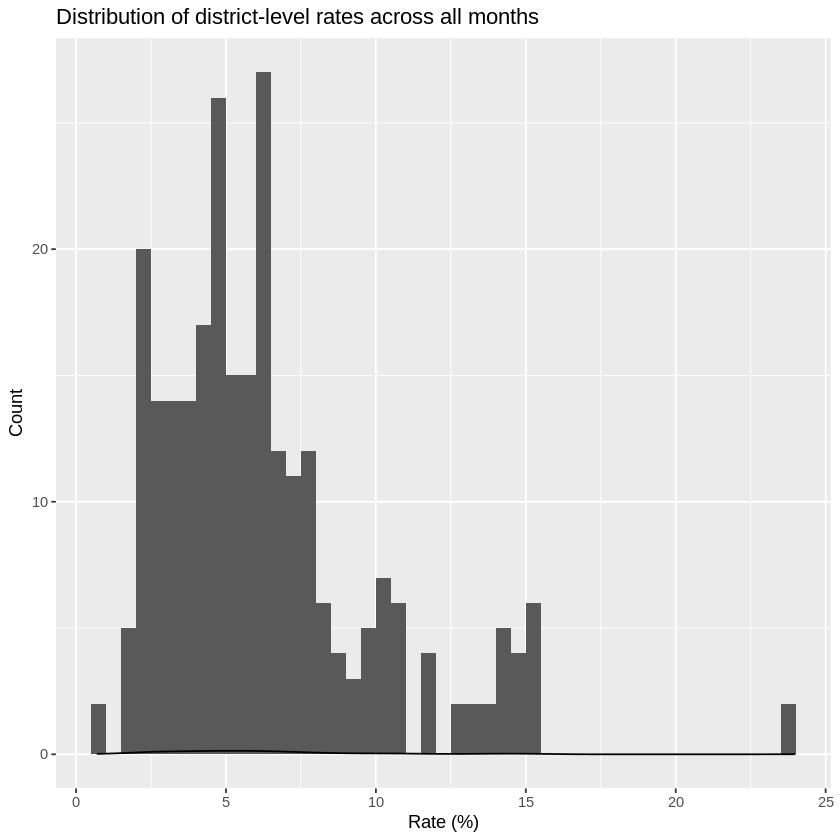

In [ ]:
ggplot(district_long, aes(x = rate)) +
  geom_histogram(binwidth = 0.5, boundary = 0, closed = "left") +
  geom_density(alpha = 0.2) +
  labs(
    title = "Distribution of district-level rates across all months",
    x = "Rate (%)",
    y = "Count"
  )

In [ ]:
bin_edges  <- c(0, 4, 5, 6, 7, 9, Inf)
bin_labels <- c("0–<4", "4–<5", "5–<6", "6–<7", "7–<9", "9+")

bin_colors <- c(
  "0–<4" = "#ffffcc",  # very light yellow (lowest)
  "4–<5" = "#ffeda0",  # light yellow
  "5–<6" = "#fed976",  # yellow-orange
  "6–<7" = "#feb24c",  # orange
  "7–<9" = "#fd8d3c",  # orange-red
  "9+"   = "#e31a1c"   # strong red (highest)
)

district_binned <- district_long |>
  mutate(
    bin = cut(
      rate,
      breaks = bin_edges,
      labels = bin_labels,
      include.lowest = TRUE,
      right = FALSE
    )
  )

bin_counts <- district_binned |>
  count(bin) |>
  mutate(prop = n / sum(n))

bin_counts


bin,n,prop
<fct>,<int>,<dbl>
0–<4,69,0.25274725
4–<5,43,0.15750916
5–<6,30,0.10989011
6–<7,39,0.14285714
7–<9,33,0.12087912
9+,48,0.17582418
NA,11,0.04029304


In [ ]:
head(district_binned)
df_final <- district_binned

month_date,month_label,district,rate,bin
<date>,<chr>,<chr>,<dbl>,<fct>
2024-01-01,Jan 2024,Bo,5.79,5–<6
2024-01-01,Jan 2024,Bombali,3.53,0–<4
2024-01-01,Jan 2024,Bonthe,7.02,7–<9
2024-01-01,Jan 2024,Kailahun,2.21,0–<4
2024-01-01,Jan 2024,Kambia,10.02,9+
2024-01-01,Jan 2024,Kenema,7.34,7–<9


In [ ]:
names(district_masks)

recolor_one_map <- function(img, month_date,
                            district_masks,
                            district_binned,
                            bin_colors) {

  # Subset to this month
  month_data <- district_binned %>%
    filter(month_date == !!month_date,
           !is.na(rate))  # skip NAs

  arr <- as.array(img)  # dims: x, y, z, cc

  for (i in seq_len(nrow(month_data))) {
    d_name  <- month_data$district[i]
    d_bin   <- as.character(month_data$bin[i])
    color   <- bin_colors[d_bin]

    if (is.na(color)) next  # skip if bin is missing or not in palette

    # get mask for this district
    mask <- district_masks[[d_name]]
    if (is.null(mask)) next

    # convert hex → RGB [0,1]
    rgb_vals <- col2rgb(color) / 255

    # apply color to masked pixels
    arr[,,1,1][mask] <- rgb_vals[1]  # R
    arr[,,1,2][mask] <- rgb_vals[2]  # G
    arr[,,1,3][mask] <- rgb_vals[3]  # B
  }

  as.cimg(arr)
}

[1] "Bo"           "Kambia"       "Bombali"      "Koinadugu"    "Western Area"
 [6] "Port_Loko"    "Tonkolili"    "Kono"         "Moyamba"      "Kenema"      
[11] "Kailahun"     "Bonthe"       "Pujehun"

Recoloring map for 19723 ...
Recoloring map for 19754 ...
Recoloring map for 19783 ...
Recoloring map for 19814 ...
Recoloring map for 19844 ...
Recoloring map for 19875 ...
Recoloring map for 19905 ...
Recoloring map for 19936 ...
Recoloring map for 19967 ...
Recoloring map for 19997 ...
Recoloring map for 20028 ...
Recoloring map for 20058 ...
Recoloring map for 20089 ...
Recoloring map for 20120 ...
Recoloring map for 20148 ...
Recoloring map for 20179 ...
Recoloring map for 20209 ...
Recoloring map for 20240 ...
Recoloring map for 20270 ...
Recoloring map for 20301 ...
Recoloring map for 20332 ...


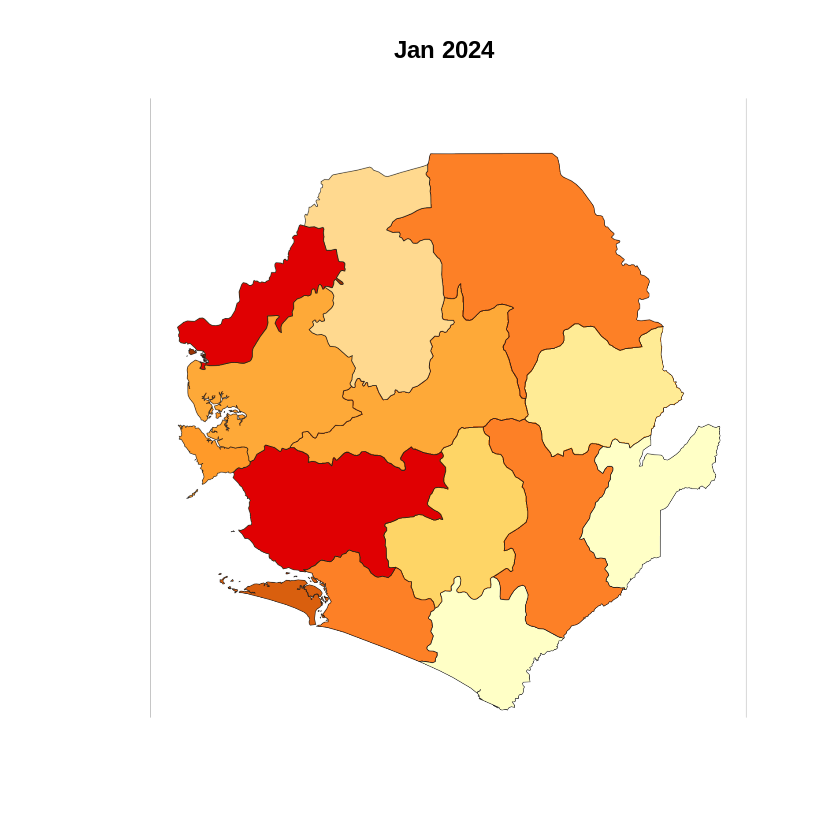

In [ ]:
month_dates <- district_rates$month_date  # same order as img_list

recolored_imgs <- vector("list", length(img_list))

for (i in seq_along(img_list)) {
  cat("Recoloring map for", month_dates[i], "...\n")
  recolored_imgs[[i]] <- recolor_one_map(
    img           = img_list[[i]],
    month_date    = month_dates[i],
    district_masks = district_masks,
    district_binned = district_binned,
    bin_colors    = bin_colors
  )
}
plot(recolored_imgs[[1]], axes = FALSE)
title(main = format(month_dates[1], "%b %Y"))


In [ ]:
n_months <- length(img_list)      # 21
train_size <- floor(0.7 * n_months)  # 14

train_idx   <- 1:train_size        # 1:14   (train)
test_idx    <- (train_size + 1):(n_months - 1)  # 15:20 (test)
holdout_idx <- n_months            # 21      (Sep 2025)

# We split the 21 images into 70% train and 30% test in chronological order.
# The final month (index 21) is reserved as a holdout for final prediction.

train_idx
test_idx
holdout_idx

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14

[1] 15 16 17 18 19 20

[1] 21

In [ ]:
# Indices for each split
n_months   <- length(img_list)          # should be 21
train_size <- floor(0.7 * n_months)     # 14

train_idx   <- 1:train_size             # 1:14
test_idx    <- (train_size + 1):(n_months - 1)  # 15:20
holdout_idx <- n_months                 # 21 (Sept 2025)


# Split images
train_imgs   <- img_list[train_idx]
test_imgs    <- img_list[test_idx]
holdout_img  <- img_list[[holdout_idx]]


# Match months to indices
# df_final is long table with one row per (month, district)
# and a month_date column that matches img_list order

month_vec <- sort(unique(df_final$month_date))
# This should be: 2024-01-01, 2024-02-01, ..., 2025-09-01

train_months   <- month_vec[train_idx]
test_months    <- month_vec[test_idx]
holdout_month  <- month_vec[holdout_idx]


# Split labels (bins/rates)

# label df contains one row per district per month
# --> extracts the labels associated with each time period
train_labels <- df_final %>%
  dplyr::filter(month_date %in% train_months)

test_labels <- df_final %>%
  dplyr::filter(month_date %in% test_months)

holdout_labels <- df_final %>%
  dplyr::filter(month_date == holdout_month)


In [ ]:
target_size <- c(224, 224)  # c(height, width)
channels    <- 3

# preprocessing to every map image --> normalized, fixed-size dataset
preprocess_cimg <- function(img, target_size = c(224, 224)) {
  # Resize: imager uses x = width, y = height
  img_resized <- imager::resize(
    img,
    size_x = target_size[2],  # width
    size_y = target_size[1]   # height
  )

  arr4 <- as.array(img_resized)  # often: x, y, z, cc  or x, y, cc

  dims <- dim(arr4)

  if (length(dims) == 4L) {
    # x, y, z, cc
    x <- dims[1]; y <- dims[2]; z <- dims[3]; cc <- dims[4]

    # keep first z-slice
    arr3 <- arr4[,,1, , drop = FALSE]  # x, y, cc
    cc <- dim(arr3)[4]
    arr3 <- array(arr3, dim = c(x, y, cc))  # force 3D: x, y, cc

  } else if (length(dims) == 3L) {
    # x, y, cc
    arr3 <- arr4

  } else if (length(dims) == 2L) {
    # grayscale: x, y -> add one channel
    x <- dims[1]; y <- dims[2]
    arr3 <- array(arr4, dim = c(x, y, 1))

  } else {
    stop("Unexpected number of dimensions in image array: ", length(dims))
  }

  # If there is an alpha channel (cc = 4), drop it: keep RGB only
  if (dim(arr3)[3] > 3) {
    arr3 <- arr3[,,1:3, drop = FALSE]
  }

  # Now arr3 is x (width) × y (height) × cc (<=3)
  # Reorder to height × width × channels
  arr_hwk <- aperm(arr3, c(2, 1, 3))  # y, x, cc

  # Scale to [0,1]
  arr_hwk <- arr_hwk / 255

  arr_hwk  # [height, width, 3]
}

In [ ]:
imgs_proc <- lapply(img_list, preprocess_cimg, target_size = target_size)

# Check one example
dim(imgs_proc[[1]])  # should be 224 224 3

[1] 224 224   3

In [ ]:
make_X_from_indices <- function(imgs_proc, idxs) {
  # subset the processed list
  sub_list <- imgs_proc[idxs]

  # assume all images have the same shape
  img_dim <- dim(sub_list[[1]])  # c(h, w, channels)
  h <- img_dim[1]
  w <- img_dim[2]
  channels <- img_dim[3]

  n <- length(sub_list)

  # flatten all images and reshape into [n, h, w, channels] (stacks indv imgs into 4d arrays for keras)
  X <- array(
    unlist(sub_list),
    dim = c(n, h, w, channels)
  )

  X
}

X_train   <- make_X_from_indices(imgs_proc, train_idx)
X_test    <- make_X_from_indices(imgs_proc, test_idx)
X_holdout <- make_X_from_indices(imgs_proc, holdout_idx)

dim(X_train)    # n_train x h x w x channels
dim(X_test)     # n_test  x h x w x channels
dim(X_holdout)  # 1       x h x w x channels


[1]  14 224 224   3

[1]   6 224 224   3

[1]   1 224 224   3

In [ ]:
length(imgs_proc)          # should be 21
dim(imgs_proc[[1]])        # e.g., 224 224 3
dim(X_train)[-1]           # should match dim(imgs_proc[[1]])
length(train_idx)          # should match dim(X_train)[1]
length(test_idx)           # should match dim(X_test)[1]

[1] 21

[1] 224 224   3

[1] 224 224   3

[1] 14

[1] 6

In [ ]:
# Extract only Bo’s monthly bins since Bo is the target we want to predict/classify

bo_labels <- df_final %>%
  filter(district == "Bo") %>%
  arrange(month_date)

# Should be same length as n_months
nrow(bo_labels)        # should be 21
bo_labels$month_date   # should line up with month_seq

# Extract bin as factor
bo_bins <- bo_labels$bin

# Keep the levels for later reference
bin_levels <- levels(bo_bins)
bin_levels
# e.g. "0–<4" "4–<5" "5–<6" "6–<7" "7–<9" "9+"

# Convert factor -> integer class indices starting at 0 (for keras::to_categorical)
y_all_idx <- as.integer(bo_bins) - 1L

# Split according to indices (labels are split in the same chronological way as imgs)
y_train_idx   <- y_all_idx[train_idx]
y_test_idx    <- y_all_idx[test_idx]
y_holdout_idx <- y_all_idx[holdout_idx]

length(y_train_idx)   # should match dim(X_train)[1]
length(y_test_idx)    # == dim(X_test)[1]
length(y_holdout_idx) # == 1

[1] 21

[1] "2024-01-01" "2024-02-01" "2024-03-01" "2024-04-01" "2024-05-01"
 [6] "2024-06-01" "2024-07-01" "2024-08-01" "2024-09-01" "2024-10-01"
[11] "2024-11-01" "2024-12-01" "2025-01-01" "2025-02-01" "2025-03-01"
[16] "2025-04-01" "2025-05-01" "2025-06-01" "2025-07-01" "2025-08-01"
[21] "2025-09-01"

[1] "0–<4" "4–<5" "5–<6" "6–<7" "7–<9" "9+"

[1] 14

[1] 6

[1] 1

In [ ]:
# keras uses one-hot encoding for classification
# e.g., bin 5-<6 --> [0, 0, 1, 0, 0, 0]
num_classes <- length(bin_levels)

y_train <- to_categorical(y_train_idx, num_classes = num_classes)
y_test  <- to_categorical(y_test_idx,  num_classes = num_classes)
# holdout we can keep as index; we don't train on it

In [ ]:
# Get image shape from X_train [#images, height, width, channels]
img_shape <- dim(X_train)
h <- img_shape[2]
w <- img_shape[3]
channels <- img_shape[4]

input_shape <- c(h, w, channels)


# Base model: ResNet50
base_model <- application_resnet50(
  weights = "imagenet",
  include_top = FALSE, # just use the convolutional part (feature extractor)
  input_shape = input_shape
)

# Freeze all convolutional layers---prevents any from being updated during training
freeze_weights(base_model)


# Build classification head
inputs <- layer_input(shape = input_shape)

x <- base_model(inputs, training = FALSE) %>% # feeds input img and outputs high-level feature map (spatial grid of deep features)
  # training = FALSE keeps batch norm layers in inference mode (important when frozen)

  layer_global_average_pooling_2d() %>% # takes feature map and avgs across spatial dims: [height, width, channels] --> [channels]
  layer_dense(units = 128, activation = "relu") %>% # trainable head: adds fully connected layer w 128 hid units, applies ReLU nonlinearity
  layer_dropout(rate = 0.5) %>% # randomly drops 50% of units during training to prevent overfitting

  layer_dense(units = num_classes, activation = "softmax") # final output layer: num_classes = number of bins (6)
  # softmax produces a probability distribution over the 6 bins (sums to 1)

model <- keras_model(inputs = inputs, outputs = x)

summary(model)

Model: "functional"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)    │           0 │   -   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ resnet50 (Functional)         │ (None, 7, 7, 2048)     │  23,587,712 │   N   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ global_average_pooling2d      │ (None, 2048)           │           0 │   -   │
│ (GlobalAveragePooling2D)      │                        │             │       │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense (Dense)                 │ (None, 128)            │     262,272 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dropou

In [ ]:
model %>% compile(
  optimizer = optimizer_adam(learning_rate = 1e-4), # adam optimizer, small learning rate
  loss      = "categorical_crossentropy", # standard loss for multi-class classification with one-hot labels
  metrics   = c("accuracy") # tracks classification accuracy during training and validation
)

In [ ]:
history <- model %>% fit(
  x = X_train, # 4D tensor of training images [n_train, h, w, 3]
  y = y_train, # one-hot labels for Bo’s bins [n_train, 6]
  epochs = 30, # passes through the entire training set 30 times
  batch_size = 2, # uses 2 images per gradient update
  validation_data = list(X_test, y_test) # After each epoch, evaluates on the test set; tracks validation loss and accuracy.
)

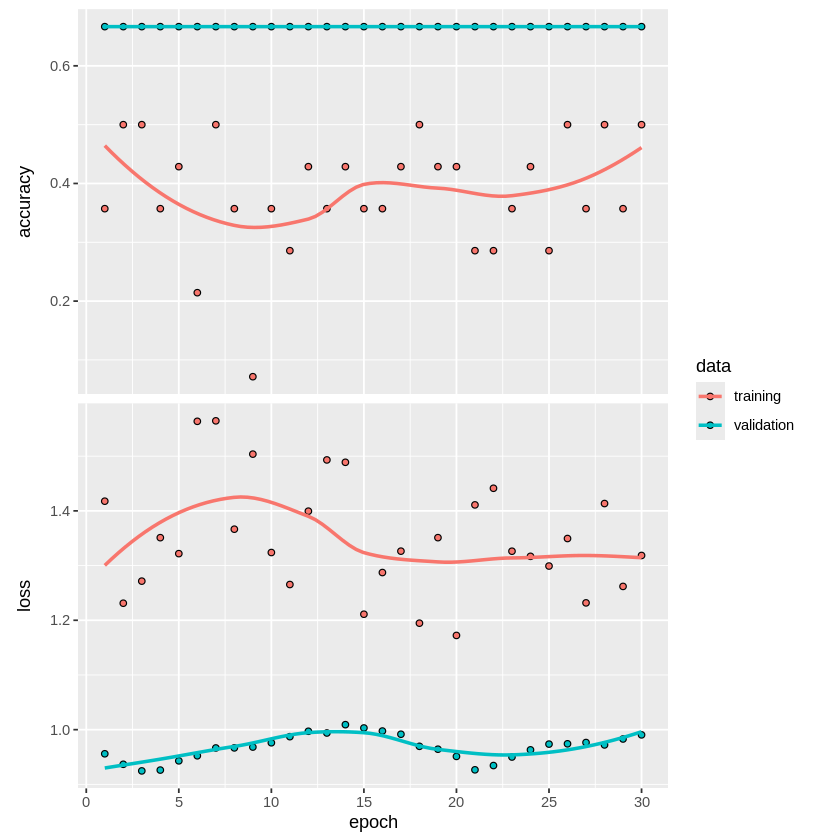

In [ ]:
plot(history)
# validation is flate 0.67 for all epochs bc we only have 6 validation samples ---> ~ 4 out of 6

The validation accuracy remains flat because the validation set contains only six images, so even one misclassification changes accuracy by 16.7%. The model consistently predicts the majority bin, producing identical validation accuracy across epochs. Training accuracy fluctuates because the dataset is extremely small. Therefore, the two curves do not converge, but this is somewhat expected when training a deep CNN on a small dataset with limited class diversity.

In [69]:
# MODEL PERFORMANCE

quiet <- function(x) suppressWarnings(x)

# 1. Predict class probabilities and hard labels for the test set
test_pred_probs <- model %>% predict(X_test)        # [n_test, num_classes]
test_pred_idx   <- max.col(test_pred_probs) - 1L    # 0-based indices

# Map indices ↔ factor labels using bin_levels
test_pred_factor  <- factor(test_pred_idx,
                            levels = 0:(num_classes - 1),
                            labels = bin_levels)

test_truth_factor <- factor(y_test_idx,
                            levels = 0:(num_classes - 1),
                            labels = bin_levels)

# 2. Build results data.frame for yardstick
test_results <- tibble(
  truth = test_truth_factor,
  pred  = test_pred_factor
)

# 3. Overall accuracy: Looks at every prediction and truth, does not care which class is involved
overall_accuracy <- accuracy(test_results, truth, pred)

# 4. Macro F1 (averaged across classes, equal weight per class)
macro_f1        <- quiet(f_meas(test_results, truth, pred, estimator = "macro"))

# 5. Macro precision & macro recall
macro_precision <- quiet(precision(test_results, truth, pred, estimator = "macro"))
macro_recall    <- quiet(recall(test_results, truth, pred, estimator = "macro"))

# 6. Per-class precision, recall, F1
per_class_precision <- quiet(test_results %>% group_by(truth) %>% precision(truth, pred))
per_class_recall    <- quiet(test_results %>% group_by(truth) %>% recall(truth, pred))
per_class_f1        <- quiet(test_results %>% group_by(truth) %>% f_meas(truth, pred))


per_class_metrics <- per_class_precision %>%
  select(truth, precision = .estimate) %>%
  left_join(
    per_class_recall %>% select(truth, recall = .estimate),
    by = "truth"
  ) %>%
  left_join(
    per_class_f1 %>% select(truth, f1 = .estimate),
    by = "truth"
  )

cat(sprintf("Accuracy:               %.3f\n", overall_accuracy$.estimate))
cat(sprintf("Precision (macro):      %.3f\n", macro_precision$.estimate))
cat(sprintf("Recall (macro):         %.3f\n", macro_recall$.estimate))
cat(sprintf("F1 Score (macro):       %.3f\n\n", macro_f1$.estimate))

cat("=====================================\n")
cat("     Per-Class Metrics (Test Set)\n")
cat("=====================================\n")

# Print each row nicely
for (i in seq_len(nrow(per_class_metrics))) {
  row <- per_class_metrics[i, ]
  cat(sprintf(
    "Class %-6s | Precision: %.3f | Recall: %.3f | F1: %.3f\n",
    as.character(row$truth),
    row$precision,
    row$recall,
    row$f1
  ))
}

cat("\n=====================================\n")
cat("          Confusion Matrix\n")
cat("=====================================\n")

print(conf_mat_table)

cat("\n(Classes with no true/pred samples may show NA in precision/recall/F1.)\n")

Accuracy:               0.667
Precision (macro):      0.667
Recall (macro):         0.500
F1 Score (macro):       0.800

     Per-Class Metrics (Test Set)
Class 5–<6 | Precision: 1.000 | Recall: 1.000 | F1: 1.000
Class 6–<7 | Precision: 0.000 | Recall: 0.000 | F1: NaN

          Confusion Matrix
      Pred
Truth  0–<4 4–<5 5–<6 6–<7 7–<9 9+
  0–<4    0    0    0    0    0  0
  4–<5    0    0    0    0    0  0
  5–<6    0    0    4    0    0  0
  6–<7    0    0    2    0    0  0
  7–<9    0    0    0    0    0  0
  9+      0    0    0    0    0  0

(Classes with no true/pred samples may show NA in precision/recall/F1.)


In [70]:
# ------------------------------------------------------------
# TRUE VALUE for Bo in September 2025
# ------------------------------------------------------------
bo_sep2025_truth <- df_final %>%
  dplyr::filter(district == "Bo",
                month_date == as.Date("2025-09-01")) %>%
  dplyr::select(month_date, district, rate, bin)

bo_sep2025_truth


# ------------------------------------------------------------
# PREDICTED VALUE for Bo in September 2025
# ------------------------------------------------------------

# predicted probability vector for Sept 2025 holdout img
holdout_pred_probs <- model %>% predict(X_holdout)

# find predicted class index
holdout_class_idx <- which.max(holdout_pred_probs) - 1L

# convert to bin label
holdout_pred_bin <- bin_levels[holdout_class_idx + 1L]

# Also show table of all probabilities
holdout_probs_df <- data.frame(
  bin  = bin_levels,
  prob = as.numeric(holdout_pred_probs[1, ])
)

holdout_pred_bin
holdout_probs_df


# ------------------------------------------------------------
# Combine TRUE + PREDICTED into a clean summary table
# ------------------------------------------------------------

bo_sep2025_summary <- data.frame(
  Month          = "2025-09",
  District       = "Bo",
  True_Bin       = as.character(bo_sep2025_truth$bin),
  Predicted_Bin  = holdout_pred_bin
)

bo_sep2025_summary


month_date,district,rate,bin
<date>,<chr>,<dbl>,<fct>
2025-09-01,Bo,4.79,4–<5


[1] "5–<6"

bin,prob
<chr>,<dbl>
0–<4,0.008617246
4–<5,0.219855204
5–<6,0.421176523
6–<7,0.288796067
7–<9,0.053368282
9+,0.008186695


Month,District,True_Bin,Predicted_Bin
<chr>,<chr>,<chr>,<chr>
2025-09,Bo,4–<5,5–<6


In [71]:
mask_out_bo <- function(img, bo_mask, fill_color = c(0.5, 0.5, 0.5)) {
  # img: cimg, cropped map
  # bo_mask: logical matrix [x, y] TRUE where Bo is
  # fill_color: RGB in [0,1]

  arr <- as.array(img)  # dims: x, y, z, cc

  # Ensure we only touch RGB channels 1:3
  for (cc in 1:3) {
    arr[,,1,cc][bo_mask] <- fill_color[cc]
  }

  as.cimg(arr)
}

bo_mask <- district_masks$Bo  # logical [x,y] for Bo on cropped maps

img_list_masked <- lapply(img_list, function(im) {
  mask_out_bo(im, bo_mask = bo_mask, fill_color = c(0.5, 0.5, 0.5))
})

target_size <- c(224, 224)

imgs_proc <- lapply(img_list_masked, preprocess_cimg, target_size = target_size)

make_X_from_indices <- function(imgs_proc, idxs) {
  sub_list <- imgs_proc[idxs]

  img_dim <- dim(sub_list[[1]])  # c(h, w, channels)
  h <- img_dim[1]; w <- img_dim[2]; channels <- img_dim[3]
  n <- length(sub_list)

  array(unlist(sub_list), dim = c(n, h, w, channels))
}

X_train   <- make_X_from_indices(imgs_proc, train_idx)
X_test    <- make_X_from_indices(imgs_proc, test_idx)
X_holdout <- make_X_from_indices(imgs_proc, holdout_idx)

dim(X_train); dim(X_test); dim(X_holdout)  # sanity check


[1]  14 224 224   3

[1]   6 224 224   3

[1]   1 224 224   3

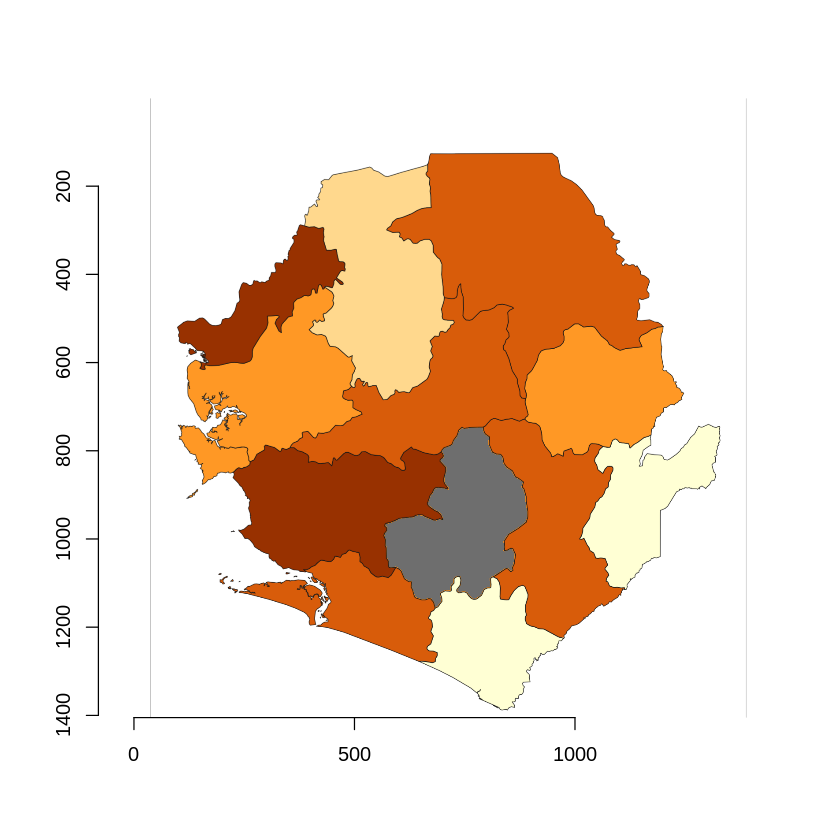

In [ ]:
plot(mask_out_bo(img_list[[1]], district_masks$Bo))

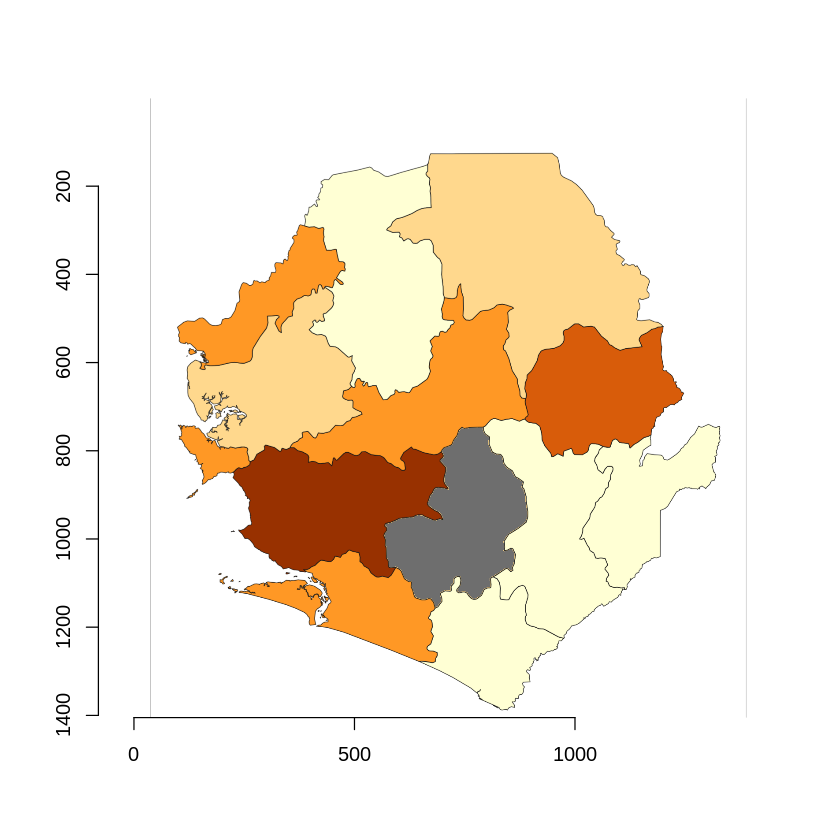

In [ ]:
plot(mask_out_bo(img_list[[21]], district_masks$Bo))

In [73]:
img_shape <- dim(X_train)
h <- img_shape[2]
w <- img_shape[3]
channels <- img_shape[4]

input_shape <- c(h, w, channels)

# Base model: ResNet50 feature extractor
base_model_masked <- application_resnet50(
  weights = "imagenet",
  include_top = FALSE,
  input_shape = input_shape
)

freeze_weights(base_model_masked)

inputs_m <- layer_input(shape = input_shape)

x_m <- base_model_masked(inputs_m, training = FALSE) %>%
  layer_global_average_pooling_2d() %>%
  layer_dense(units = 128, activation = "relu") %>%
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = num_classes, activation = "softmax")

model_masked <- keras_model(inputs = inputs_m, outputs = x_m)

summary(model_masked)

model_masked %>% compile(
  optimizer = optimizer_adam(learning_rate = 1e-4),
  loss      = "categorical_crossentropy",
  metrics   = c("accuracy")
)

history_masked <- model_masked %>% fit(
  x = X_train,
  y = y_train,  # same labels as before (Bo bins)
  epochs = 30,
  batch_size = 2,
  validation_data = list(X_test, y_test)
)

Model: "functional_1"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)    │           0 │   -   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ resnet50 (Functional)         │ (None, 7, 7, 2048)     │  23,587,712 │   N   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ global_average_pooling2d_1    │ (None, 2048)           │           0 │   -   │
│ (GlobalAveragePooling2D)      │                        │             │       │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_2 (Dense)               │ (None, 128)            │     262,272 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ drop

In [77]:
# Predict on masked test images
test_pred_probs_m <- predict(model_masked, X_test)   # or X_test_masked if you used that name
test_pred_idx_m   <- max.col(test_pred_probs_m) - 1L  # 0-based indices


In [78]:
# Map to factor labels
test_pred_factor_m  <- factor(
  test_pred_idx_m,
  levels = 0:(num_classes - 1),
  labels = bin_levels
)

test_truth_factor_m <- factor(
  y_test_idx,
  levels = 0:(num_classes - 1),
  labels = bin_levels
)

# Results tibble for yardstick
test_results_m <- tibble(
  truth = test_truth_factor_m,
  pred  = test_pred_factor_m
)


overall_accuracy_m <- accuracy(test_results_m, truth, pred)

macro_f1_m <- quiet(
  f_meas(test_results_m, truth, pred, estimator = "macro")
)

macro_precision_m <- quiet(
  precision(test_results_m, truth, pred, estimator = "macro")
)

macro_recall_m <- quiet(
  recall(test_results_m, truth, pred, estimator = "macro")
)

per_class_precision_m <- quiet(
  test_results_m %>%
    group_by(truth) %>%
    precision(truth, pred)
)

per_class_recall_m <- quiet(
  test_results_m %>%
    group_by(truth) %>%
    recall(truth, pred)
)

per_class_f1_m <- quiet(
  test_results_m %>%
    group_by(truth) %>%
    f_meas(truth, pred)
)

per_class_metrics_m <- per_class_precision_m %>%
  select(truth, precision = .estimate) %>%
  left_join(
    per_class_recall_m %>% select(truth, recall = .estimate),
    by = "truth"
  ) %>%
  left_join(
    per_class_f1_m %>% select(truth, f1 = .estimate),
    by = "truth"
  )

conf_mat_table_m <- table(
  Truth = test_results_m$truth,
  Pred  = test_results_m$pred
)


cat(sprintf("Accuracy (masked):          %.3f\n", overall_accuracy_m$.estimate))
cat(sprintf("Precision (macro, masked):  %.3f\n", macro_precision_m$.estimate))
cat(sprintf("Recall (macro, masked):     %.3f\n", macro_recall_m$.estimate))
cat(sprintf("F1 Score (macro, masked):   %.3f\n\n", macro_f1_m$.estimate))

cat("Per-Class Metrics (masked test set):\n")
for (i in seq_len(nrow(per_class_metrics_m))) {
  row <- per_class_metrics_m[i, ]
  cat(sprintf(
    "Class %-6s | Precision: %.3f | Recall: %.3f | F1: %.3f\n",
    as.character(row$truth),
    row$precision,
    row$recall,
    row$f1
  ))
}

cat("\nConfusion Matrix (masked test set):\n")
print(conf_mat_table_m)


Accuracy (masked):          0.667
Precision (macro, masked):  0.667
Recall (macro, masked):     0.500
F1 Score (macro, masked):   0.800

Per-Class Metrics (masked test set):
Class 5–<6 | Precision: 1.000 | Recall: 1.000 | F1: 1.000
Class 6–<7 | Precision: 0.000 | Recall: 0.000 | F1: NaN

Confusion Matrix (masked test set):
      Pred
Truth  0–<4 4–<5 5–<6 6–<7 7–<9 9+
  0–<4    0    0    0    0    0  0
  4–<5    0    0    0    0    0  0
  5–<6    0    0    4    0    0  0
  6–<7    0    0    2    0    0  0
  7–<9    0    0    0    0    0  0
  9+      0    0    0    0    0  0


In [80]:
# ------------------------------------------------------------
# TRUE VALUE for Bo in September 2025  (same as before)
# ------------------------------------------------------------
bo_sep2025_truth <- df_final %>%
  dplyr::filter(district == "Bo",
                month_date == as.Date("2025-09-01")) %>%
  dplyr::select(month_date, district, rate, bin)

bo_sep2025_truth


# ------------------------------------------------------------
# PREDICTED VALUE for Bo in September 2025 (Bo MASKED OUT)
# ------------------------------------------------------------

# predicted probability vector for Sept 2025 *masked* holdout img
holdout_pred_probs_m <- predict(model_masked, X_holdout)

# find predicted class index (0-based)
holdout_class_idx_m <- which.max(holdout_pred_probs_m) - 1L

# convert to bin label
holdout_pred_bin_m <- bin_levels[holdout_class_idx_m + 1L]

# Also show table of all probabilities
holdout_probs_df_m <- data.frame(
  bin  = bin_levels,
  prob = as.numeric(holdout_pred_probs_m[1, ])
)

holdout_pred_bin_m
holdout_probs_df_m


# ------------------------------------------------------------
# Combine TRUE + MASKED-PREDICTED into a clean summary table
# ------------------------------------------------------------

bo_sep2025_summary_masked <- data.frame(
  Month                 = "2025-09",
  District              = "Bo",
  True_Bin              = as.character(bo_sep2025_truth$bin),
  Predicted_Bin_Masked  = holdout_pred_bin_m
)

bo_sep2025_summary_masked


month_date,district,rate,bin
<date>,<chr>,<dbl>,<fct>
2025-09-01,Bo,4.79,4–<5


[1] "5–<6"

bin,prob
<chr>,<dbl>
0–<4,0.011142994
4–<5,0.208571613
5–<6,0.444702476
6–<7,0.265611470
7–<9,0.062812224
9+,0.007159117


Month,District,True_Bin,Predicted_Bin_Masked
<chr>,<chr>,<chr>,<chr>
2025-09,Bo,4–<5,5–<6


Umasked VS Masked Models

In [83]:
cat("==============================================\n")
cat("         MODEL PERFORMANCE COMPARISON\n")
cat("==============================================\n\n")

cat("Unmasked Model (Bo visible):\n")
cat(sprintf("  Accuracy:        %.3f\n", overall_accuracy$.estimate))
cat(sprintf("  PrecisionMacro:  %.3f\n", macro_precision$.estimate))
cat(sprintf("  RecallMacro:     %.3f\n", macro_recall$.estimate))
cat(sprintf("  F1Macro:         %.3f\n\n", macro_f1$.estimate))

cat("Masked Model (Bo region blanked out):\n")
cat(sprintf("  Accuracy:        %.3f\n", overall_accuracy_m$.estimate))
cat(sprintf("  PrecisionMacro:  %.3f\n", macro_precision_m$.estimate))
cat(sprintf("  RecallMacro:     %.3f\n", macro_recall_m$.estimate))
cat(sprintf("  F1Macro:         %.3f\n\n", macro_f1_m$.estimate))


         MODEL PERFORMANCE COMPARISON

Unmasked Model (Bo visible):
  Accuracy:        0.667
  PrecisionMacro:  0.667
  RecallMacro:     0.500
  F1Macro:         0.800

Masked Model (Bo region blanked out):
  Accuracy:        0.667
  PrecisionMacro:  0.667
  RecallMacro:     0.500
  F1Macro:         0.800



In [81]:
comparison_summary <- data.frame(
  Model      = c("Unmasked CNN", "Masked CNN"),
  Accuracy   = c(overall_accuracy$.estimate,
                 overall_accuracy_m$.estimate),
  F1_Macro   = c(macro_f1$.estimate,
                 macro_f1_m$.estimate),
  Predicted_Sept2025 = c(holdout_pred_bin,
                         holdout_pred_bin_m),
  True_Sept2025      = as.character(bo_sep2025_truth$bin)
)

comparison_summary

Model,Accuracy,F1_Macro,Predicted_Sept2025,True_Sept2025
<chr>,<dbl>,<dbl>,<chr>,<chr>
Unmasked CNN,0.6666667,0.8,5–<6,4–<5
Masked CNN,0.6666667,0.8,5–<6,4–<5


In [82]:
cat("==============================================\n")
cat("      PREDICTION COMPARISON: SEPT 2025\n")
cat("==============================================\n\n")

cat(sprintf("True Bo Bin (Sept 2025):        %s\n",
            as.character(bo_sep2025_truth$bin)))

cat(sprintf("Predicted (Unmasked model):     %s\n",
            holdout_pred_bin))

cat(sprintf("Predicted (Masked model):       %s\n\n",
            holdout_pred_bin_m))


      PREDICTION COMPARISON: SEPT 2025

True Bo Bin (Sept 2025):        4–<5
Predicted (Unmasked model):     5–<6
Predicted (Masked model):       5–<6

